In [1]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
figsize(8, 5)
import matplotlib.pyplot as plt
plt.style.use('bmh')
import scipy.stats as stats
import seaborn as sns
import pymc3 as pm
RANDOM_SEED = 20090425

<div class="alert alert-info">
Questions for data 
</div>

Is the mean-log-radon value greater than the regulated level of 4 pCi/L in Hennepin county

What is the probability that any randomly-chosen household in Hennepin county has a reading of greater than 4

In [44]:
df = pd.read_csv('radon.csv', index_col=0)
df.head()

,idnum,state,state2,stfips,zip,region,typebldg,floor,room,basement,...,pcterr,adjwt,dupflag,zipflag,cntyfips,county,fips,Uppm,county_code,log_radon
0,5081.0,MN,MN,27.0,55735,5.0,1.0,1.0,3.0,N,...,9.7,1146.499190,1.0,0.0,1.0,AITKIN,27001.0,0.502054,0,0.832909
1,5082.0,MN,MN,27.0,55748,5.0,1.0,0.0,4.0,Y,...,14.5,471.366223,0.0,0.0,1.0,AITKIN,27001.0,0.502054,0,0.832909
2,5083.0,MN,MN,27.0,55748,5.0,1.0,0.0,4.0,Y,...,9.6,433.316718,0.0,0.0,1.0,AITKIN,27001.0,0.502054,0,1.098612
3,5084.0,MN,MN,27.0,56469,5.0,1.0,0.0,4.0,Y,...,24.3,461.623670,0.0,0.0,1.0,AITKIN,27001.0,0.502054,0,0.095310
4,5085.0,MN,MN,27.0,55011,3.0,1.0,0.0,4.0,Y,...,13.8,433.316718,0.0,0.0,3.0,ANOKA,27003.0,0.428565,1,1.163151


In [45]:
hennepin_radon = df.query('county=="HENNEPIN"').log_radon
hennepin_radon[:5]

264    2.079442
265    1.223775
266    0.788457
267    0.530628
268    1.410987
Name: log_radon, dtype: float64

In [46]:
print(f"The hennepin dataframe has a shape of {hennepin_radon.shape}")

The hennepin dataframe has a shape of (105,)


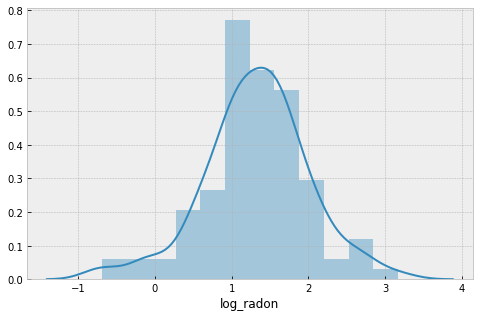

In [47]:
#Histogram to get a view of the dustribution
sns.distplot(hennepin_radon)

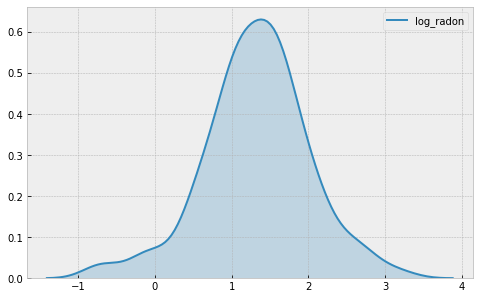

In [48]:
sns.kdeplot(hennepin_radon, shade=True);

<div class="alert alert-danger">
$Step$ $1$: $Write$ $Probability$ $Model$ 
</div>
<div class="alert alert-danger">
$Likelihood$ $functions$ $for $ $the $ $observations$ $and$ $Prior$ $Statement$ $for$ $unknown$ $quantities$
</div>
<div class="alert alert-success">
$Likelihood$ $functions$ $for $ $the $ $observations$ $is$ $Normal$ $Distribution$ 
</div>

The sampleing distribution from the Hennepin datasets appears normally distributed. The sampling distribution $likelihood$ for the data:

$y_i$ is the log_radon

$$y_i \sim N(\mu, \sigma^2)$$

<div class="alert alert-success">
$Because$ $the$ $likelihood$ $distribution$ $has$ $two$ $unknown$ $parameters$, $\mu$ $and$ $\sigma2$, $the$ $Prior$ $will$ $have$ $two$ $values$
</div>

Since the mean can take any real value (since it is on the log scale), we will use another normal distribution here, and specify a large variance to allow the possibility of very large or very small values:

$$\mu \sim N(0, 10^2)$$

For the standard deviation, we know that the true value must be positive (no negative variances!). I will choose a uniform prior bounded from below at zero and from above at a value that is sure to be higher than any plausible value the true standard deviation (on the log scale) could take.

$$\sigma \sim U(0, 10)$$

We can encode these in a Python model, using the PyMC3 package, as follows:




In [49]:
#Prior
from pymc3 import Model, Uniform, Normal

with Model() as radon_model:
    
    u = Normal('u', mu=0, sd=10)
    s = Uniform('s', 0, 10)
 

In [50]:
RANDOM_SEED = 20090425
#Likelihood
#Notice that mu and sigma are not integer values

with radon_model:
    
    y = Normal('y', mu = u, sd = s, observed = hennepin_radon)


In [51]:
from pymc3 import fit
with radon_model:
    samples = fit(random_seed=RANDOM_SEED).sample(1000)

Average Loss = 136.32: 100%|██████████| 10000/10000 [00:01<00:00, 8706.04it/s]
Finished [100%]: Average Loss = 136.28


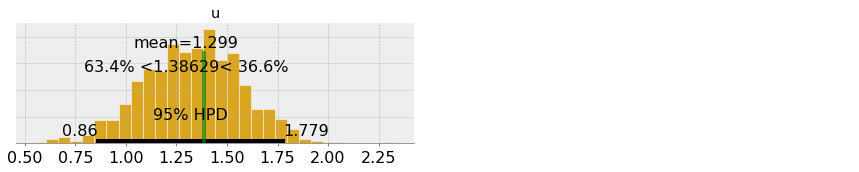

In [52]:
from pymc3 import plot_posterior

plot_posterior(samples, varnames=['u'], ref_val=np.log(4), color="GoldenRod");


The Posterior distribution is the mean expected value of log_radon

There is a 63.4% probability that the mean (mu) is less than log(4) and a 36.6% probaility that mean is greater than log(4)

The true value is between 0.86 and 1.779


<div class="alert alert-danger">
$Posterior$ $Predictive$ $Distribution$ 
</div>
<div class="alert alert-danger">
$Predition$ $is$: $function$ $of$ $the$ $parameters$ $and$ $the$ $stochastic$ $process$ 
</div>

What is the probability that a given household has a log-radon measurement larger than one? To answer this, we make use of the **posterior predictive distribution**.

$$p(z |y) = \int_{\theta} p(z |\theta) p(\theta | y) d\theta$$

where here $z$ is the predicted value and y is the data used to fit the model.

We can estimate this from the posterior samples of the parameters in the model.

In [53]:
mus = samples['u']
sigmas = samples['s']

In [55]:
random_samples = Normal.dist(mus, sigmas).random()

In [56]:
(random_samples > np.log(4)).mean()

0.47599999999999998

The posterior probability that a randomly selected household in Hennepin County contains radon levels in excess of 4 pCi/L is 0.48

<div class="alert alert-danger">
$Check$ $Model$: $Posterior$ $Predictive$ $Check$
</div>
the simulated data needs to cpture the observed data

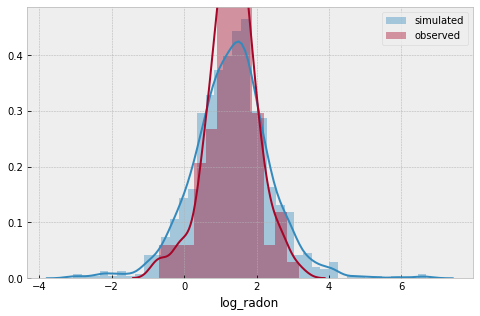

In [60]:
sns.distplot(random_samples, label='simulated')
sns.distplot(hennepin_radon, label='observed')
plt.legend()

### 2nd Example

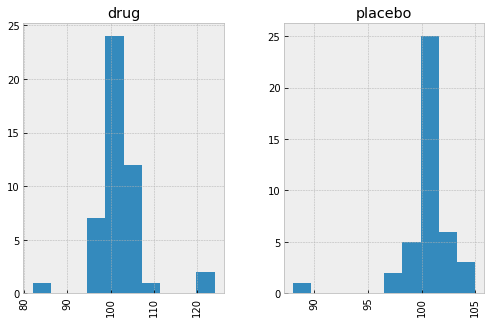

In [2]:
drug = pd.DataFrame(dict(iq=(101,100,102,104,102,97,105,105,98,101,100,123,105,103,100,95,102,106,
        109,102,82,102,100,102,102,101,102,102,103,103,97,97,103,101,97,104,
        96,103,124,101,101,100,101,101,104,100,101),
                         group='drug'))
placebo = pd.DataFrame(dict(iq=(99,101,100,101,102,100,97,101,104,101,102,102,100,105,88,101,100,
           104,100,100,100,101,102,103,97,101,101,100,101,99,101,100,100,
           101,100,99,101,100,102,99,100,99),
                            group='placebo'))

trial_data = pd.concat([drug, placebo], ignore_index=True)
trial_data.hist('iq', by='group');

<div class="alert alert-danger">
$Normal$ $Distributions$: $have $ $skinny$ $tails$
</div>

95% of the values have to be within 3 standard deviations of the mean


<div class="alert alert-danger">
$T$ $Distributions$ $have $ $fat$ $tails$ $which$ $allows$ $for $ $outliers$ 
</div>

Looking at the distributions above, we will use T distributions


$$f(x|\mu,\lambda,\nu) = \frac{\Gamma(\frac{\nu + 1}{2})}{\Gamma(\frac{\nu}{2})} \left(\frac{\lambda}{\pi\nu}\right)^{\frac{1}{2}} \left[1+\frac{\lambda(x-\mu)^2}{\nu}\right]^{-\frac{\nu+1}{2}}$$
           
the degrees-of-freedom parameter essentially specifies the "normality" of the data, since larger values of $\nu$ make the distribution converge to a normal distribution, while small values (close to zero) result in heavier tails.

Thus, the likelihood functions of our model are specified as follows:

$$\begin{align}
y^{(drug)}_i &\sim T(\nu, \mu_1, \sigma_1) \\
y^{(placebo)}_i &\sim T(\nu, \mu_2, \sigma_2)
\end{align}$$


In [20]:
#Prior

from pymc3 import StudentT, Normal, Model, plot_posterior, Uniform, fit

y = StudentT.dist(nu=3)
t = y.random(size = 10_000)

yn = Normal.dist(mu=0, sd=1)
n = yn.random(size = 10_000)
 

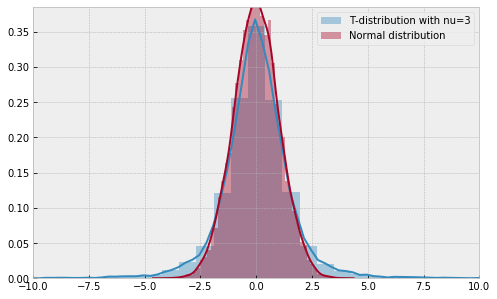

In [21]:
sns.distplot(t, label="T-distribution with nu=3")
sns.distplot(n, label="Normal distribution")
plt.legend()
plt.xlim(-10,10);

<div class="alert alert-danger">
$Prior$ : $One$: $for$ $Placebo$ $and$ $drug$
</div>

In [22]:
#Mu
with Model() as drug_model:
    u_0 = Normal("u_0" ,100, sd=10)
    u_1 = Normal("u_1", 100, sd=10)




In [23]:
# Sigma
with drug_model:
    s_0 = Uniform('s_0', lower= 0, upper =20) 
    s_1 = Uniform('s_1', lower =0, upper = 20)

### Likelihood
For the degrees-of-freedom parameter $\nu$, we will use an **exponential** distribution with a mean of 30; this allocates high prior probability over the regions of the parameter that describe the range from normal to heavy-tailed data under the Student-T distribution.

In [24]:
from pymc3 import Exponential

with drug_model:

    v = Exponential('v_minus_one', 1/29) + 1

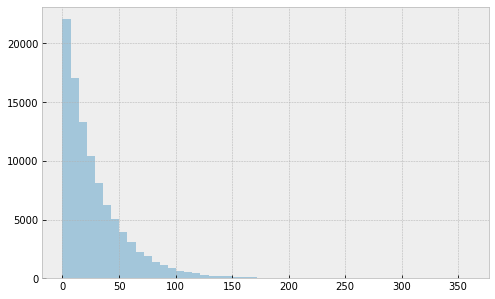

In [25]:
sns.distplot(Exponential.dist(1/29.0).random(size=100_000), kde=False)

<div class="alert alert-success">
$Put$ $the$ $Prior$ $into$ $Likelihood$
</div>

In [26]:
from pymc3 import StudentT

with drug_model:
    
    drug_like= StudentT('drug_like', nu=v, mu=u_1, lam=s_1**-2, observed=drug.iq)
    placebo_like = StudentT('placebo_like', nu=v, mu=u_0, lam=s_0**-2, observed=placebo.iq)

<div class="alert alert-danger">
$Calculate$ $the$ $difference$ $in$ $means$
</div>

In [27]:
from pymc3 import Deterministic

with drug_model:
    
    diff_of_means = Deterministic("difference of means", u_1 - u_0)
    
    effect_size = Deterministic("effect size", 
                              diff_of_means / np.sqrt((s_1**2 + s_0**2) / 2))

In [28]:
with drug_model:
    drug_trace = fit(random_seed = RANDOM_SEED).sample(10000)

Average Loss = 244.48: 100%|██████████| 10000/10000 [00:02<00:00, 4930.92it/s]
Finished [100%]: Average Loss = 244.4


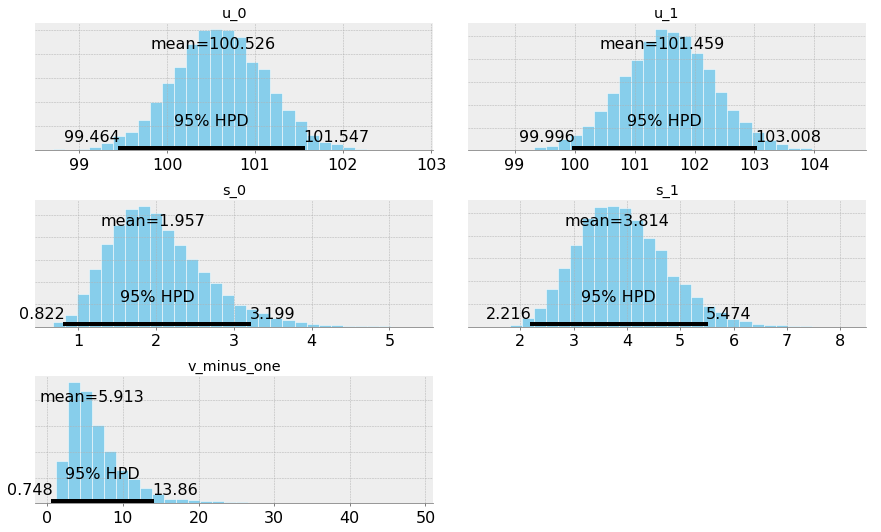

In [29]:
plot_posterior(drug_trace[100:], 
                varnames=['u_0', 'u_1', 's_0', 's_1', 'v_minus_one'],
                color='#87ceeb');

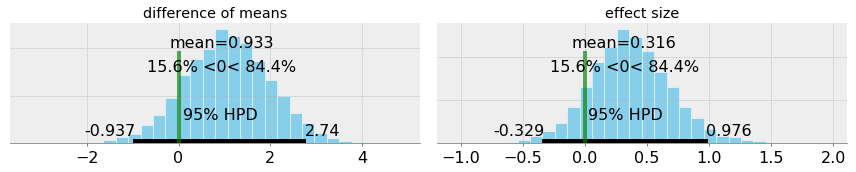

In [30]:
plot_posterior(drug_trace[100:], 
          varnames=['difference of means', 'effect size'],
          ref_val=0,
          color='#87ceeb');

> The posterior probability that the mean IQ of subjects in the treatment group is greater than that of the control group is 0.901.

##### Example 3

In [35]:
%ls

List of OECD Member countries - Ratification of the Convention on the OECD - OECD.html*
ebola/
medals.csv*
microbiome/
nashville_precip.txt*
olympics.1996.txt*
radon.csv*
salmon.dat*
test_scores.csv*
titanic.xls*
vlbw.csv*


In [36]:
nash_precip = pd.read_table("nashville_precip.txt", delimiter="\s+", na_values='NA', index_col=0)
nash_precip.head(2)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
1871,2.76,4.58,5.01,4.13,3.30,2.98,1.58,2.36,0.95,1.31,2.13,1.65
1872,2.32,2.11,3.14,5.91,3.09,5.17,6.10,1.65,4.50,1.58,2.25,2.38


- What is the probability that the expected rainfall in January is larger than in July?

- What is the probability the January rainfall exceeds July rainfall in a given year?

In [76]:
july_rain = nash_precip['Jul']
jan_rain = nash_precip['Jan']

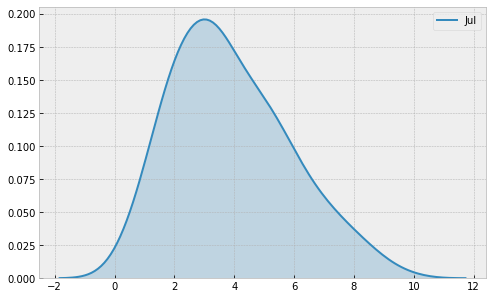

In [38]:
sns.kdeplot(july, shade=True)

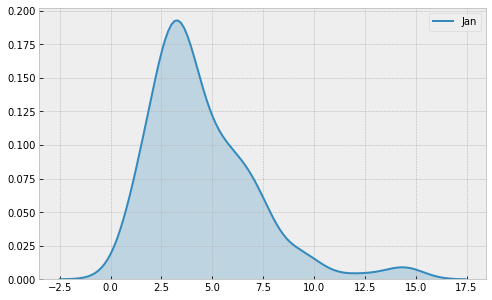

In [39]:
sns.kdeplot(jan, shade=True)

In [67]:
from pymc3 import Gamma

x = Gamma.dist(alpha =6.0 , beta=1.0, mu=5.0,sd = 4.0 )
samples = x.random(size=10_000)

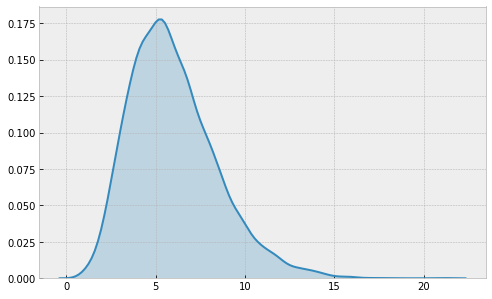

In [68]:
sns.kdeplot(samples, shade=True)

In [79]:
from pymc3 import Deterministic


with Model() as rainfall_model:
    
    σ = Uniform("σ", lower =0, upper =100)
    
    β = Uniform("β", lower =1, upper =6)
    
    α = Uniform("α", lower =1, upper =9)
    
    mu_jan = Normal('mu_jan' ,mu=2.75, sd=0.8)
    mu_jul = Normal('mu_jul',mu=2.75, sd=0.8)
    
    jan = Gamma('jan', alpha = α, beta= β, mu= mu_jan, sd = σ, observed = july_rain)
    jul = Gamma('jul', alpha = α, beta= β, mu= mu_jul, sd = σ, observed = jan_rain)
    
    d = Deterministic('d', mu_jan - mu_jul)

In [80]:
with rainfall_model:
    
    samples = fit(20_000).sample(1000)

Average Loss = 623.37: 100%|██████████| 20000/20000 [00:03<00:00, 5575.68it/s]
Finished [100%]: Average Loss = 623.35


array([<matplotlib.axes._subplots.AxesSubplot object at 0x11fc7ab00>], dtype=object)

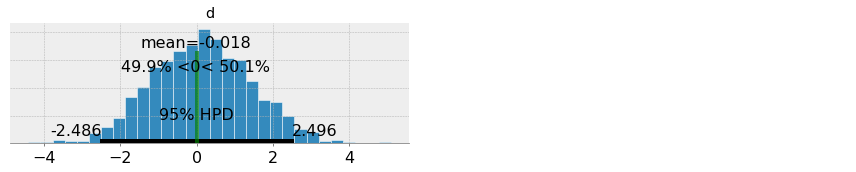

In [82]:
plot_posterior(samples, varnames=['d'], ref_val=0)

<div class="alert alert-danger">
$From$ $Hackers$ $Chapter$ $2$ 
</div>

To setup a Bayesian model, assign prior distrbutions to unknown quantities. *A priori*, what do we think $p_A$ might be? For this example, there is no strong conviction about $p_A$, so for now, $p_A$ is uniform over [0,1]:

In [28]:
from pymc3 import StudentT, Normal, Model, plot_posterior, Uniform, fit 

with Model() as internet_model:
    p = pm.Uniform('p',lower=0, upper=1)

Consider $p_A = 0.05$, and $N = 1500$ users shown site A, and we will simulate whether the user made a purchase or not. To simulate this from $N$ trials, we will use a *Bernoulli* distribution: if  $X\ \sim \text{Ber}(p)$, then $X$ is 1 with probability $p$ and 0 with probability $1 - p$. Of course, in practice we do not know $p_A$, but we will use it here to simulate the data.

In [29]:
#Simulation

from pymc3 import Bernoulli

y = Bernoulli.dist(p=0.05)
t = y.random(size = 1500)



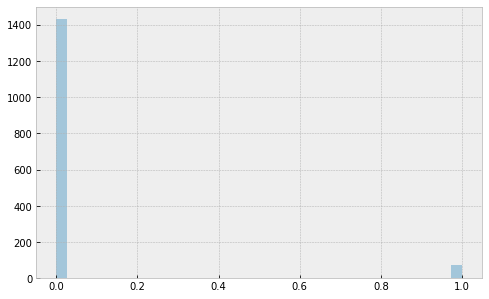

In [30]:
sns.distplot(t,kde=False)

In [31]:
print(f"What is the observed frequency in Group A?:\t{t.mean():.4f}")
print(f"Does the observed frequency equal the true frequency: {t.mean() == .05}")

What is the observed frequency in Group A?:	0.0473
Does the observed frequency equal the true frequency: False


In [32]:
t

array([0, 0, 0, ..., 0, 0, 0])

In [33]:
#include the observations, which are Bernoulli

with internet_model:
    obs = pm.Bernoulli("obs", p, observed = t)
    
    step = pm.Metropolis()
    trace = pm.sample(18000, step=step)
    burned_trace = trace[1000:]

100%|██████████| 18500/18500 [00:02<00:00, 6397.34it/s]


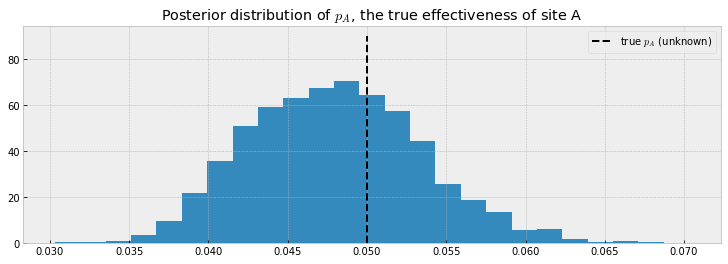

In [35]:
p_true = 0.05
figsize(12.5, 4)

plt.title("Posterior distribution of $p_A$, the true effectiveness of site A")
plt.vlines(p_true, 0, 90, linestyle="--", label="true $p_A$ (unknown)")
plt.hist(burned_trace["p"], bins=25, histtype="stepfilled", normed=True)
plt.legend();

The difference between  pApA  and  pBpB . Infer  pApA ,  pBpB , and  delta=pA−pBdelta=pA−pB , all at once. We can do this using PyMC3's deterministic variables. (assume for this exercise that  pB=0.04pB=0.04 , so  delta=0.01delta=0.01 ,  NB=750NB=750  (signifcantly less than  NANA ) and we will simulate site B's data like we did for site A's data )

In [45]:
figsize(12, 4)

#These two unknown quantities are unknown to us
true_p_A = 0.05
true_p_B = 0.04

#Unequal sample sizes
N_A = 1500
N_B = 750

bern_A = pm.Bernoulli.dist(true_p_A)
bern_B = pm.Bernoulli.dist(true_p_B)

observation_A = bern_A.random(size = N_A)
observation_B = bern_B.random(size= N_B)

print("Obs from Site A: ", observation_A[:30], "...")
print("Obs from Site B: ", observation_B[:30], "...")

Obs from Site A:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0] ...
Obs from Site B:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] ...


In [47]:
print(observation_A.mean())
print(observation_B.mean())

0.0506666666667
0.0413333333333


In [44]:
observation_A.mean()

0.042000000000000003

In [48]:
with Model() as hacker2:
    p_A = pm.Uniform('p_A', lower=0, upper=1)
    p_B = pm.Uniform('p_B', lower=0, upper=1)
    
    
    # Define the deterministic delta function. This is our unknown of interest.
    δ = pm.Deterministic('δ', p_A - p_B)
    
    # Set of observations, in this case we have two observation datasets.
    obs_A = pm.Bernoulli('obs_A', p_A, observed =observation_A)
    obs_B = pm.Bernoulli('obs_B', p_B, observed =observation_B)
    
    # To be explained in chapter 3.
    step = pm.Metropolis()
    trace = pm.sample(20000, step=step)
    burned_trace=trace[1000:]
    
    
    
    
    
    

100%|██████████| 20500/20500 [00:06<00:00, 3134.53it/s]


In [49]:
p_A_samples = burned_trace['p_A']
p_B_samples = burned_trace['p_B']
delta_samples = burned_trace['δ']

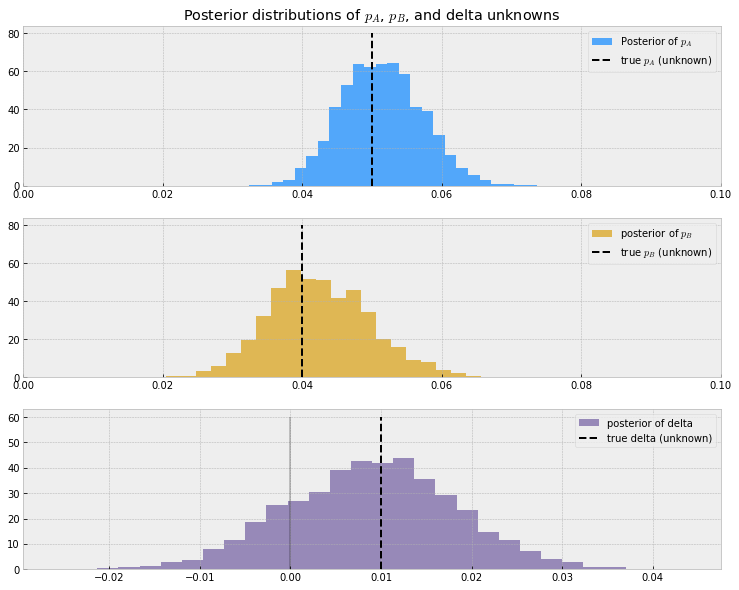

In [51]:
figsize(12.5, 10)

ax = plt.subplot(311)

plt.xlim(0, 0.1)

plt.hist(p_A_samples, histtype='stepfilled', bins=25, alpha=0.75,
        label = "Posterior of $p_A$", color= "DodgerBlue", normed=True)
plt.vlines(true_p_A, 0, 80, linestyle="--", label="true $p_A$ (unknown)")
plt.legend(loc="upper right")
plt.title("Posterior distributions of $p_A$, $p_B$, and delta unknowns")

ax = plt.subplot(312)

plt.xlim(0, .1)
plt.hist(p_B_samples, histtype='stepfilled', bins=25, alpha=0.75,
         label="posterior of $p_B$", color="GoldenRod", normed=True)
plt.vlines(true_p_B, 0, 80, linestyle="--", label="true $p_B$ (unknown)")
plt.legend(loc="upper right")

ax = plt.subplot(313)
plt.hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.75,
         label="posterior of delta", color="#7A68A6", normed=True)
plt.vlines(true_p_A - true_p_B, 0, 60, linestyle="--",
           label="true delta (unknown)")
plt.vlines(0, 0, 60, color="black", alpha=0.2)
plt.legend(loc="upper right");

In [52]:
with hacker2:
    
    samples = fit(20_000).sample(1000)

Average Loss = 438.11: 100%|██████████| 20000/20000 [00:04<00:00, 4884.04it/s]
Finished [100%]: Average Loss = 438.11


array([<matplotlib.axes._subplots.AxesSubplot object at 0x11d4994a8>], dtype=object)

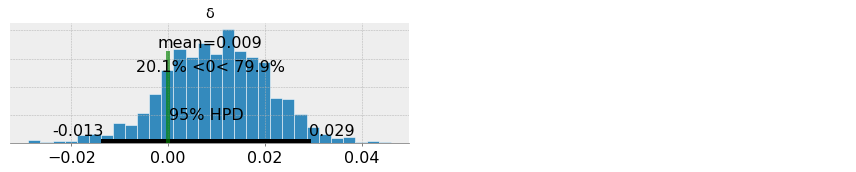

In [53]:
plot_posterior(samples, varnames=['δ'], ref_val=0)

# Binomial
the binomial distribution has 2 parameters: $N$, a positive integer representing $N$ trials or number of instances of potential events, and $p$, the probability of an event occurring in a single trial. Like the Poisson distribution, it is a discrete distribution, but unlike the Poisson distribution, it only weighs integers from $0$ to $N$. The mass distribution looks like:

$$P( X = k ) =  {{N}\choose{k}}  p^k(1-p)^{N-k}$$

If $X$ is a binomial random variable with parameters $p$ and $N$, denoted $X \sim \text{Bin}(N,p)$, then $X$ is the number of events that occurred in the $N$ trials (obviously $0 \le X \le N$). The larger $p$ is (while still remaining between 0 and 1), the more events are likely to occur. The expected value of a binomial is equal to $Np$. Below we plot the mass probability distribution for varying parameters. 


In [70]:
from pymc3 import Binomial

x1 = Binomial.dist(n = 10, p = 0.4)
x2 = Binomial.dist(n = 10, p = 0.9)

samples_x1 = x1.random(size=10_000)
samples_x2 = x2.random(size=10_000)

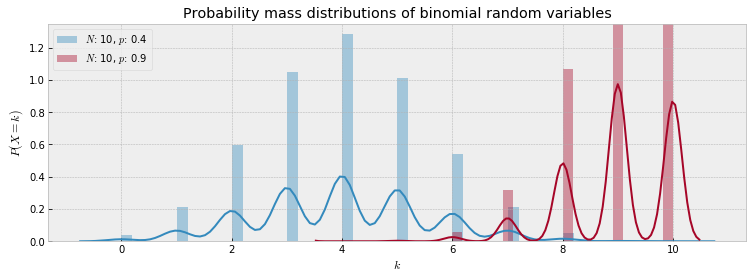

In [71]:
N = 10
p_1 = 0.4
p_2 = 0.9

sns.distplot(samples_x1, label = f"$N$: {N}, $p$: {p_1}")
sns.distplot(samples_x2, label = f"$N$: {N}, $p$: {p_2}")
plt.xlabel("$k$")
plt.ylabel("$P(X = k)$")
plt.legend()
plt.title("Probability mass distributions of binomial random variables")


In [73]:
samples_x2.mean()

9.0023

In [74]:
samples_x2.max()

10

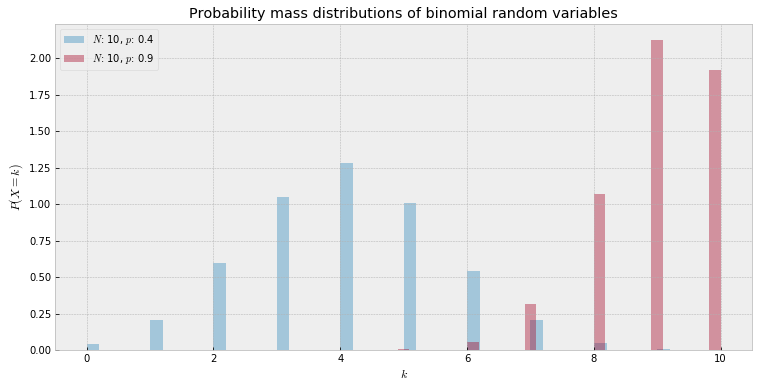

In [86]:
N = 10
p_1 = 0.4
p_2 = 0.9
sns.distplot(samples_x1, hist=True,kde=False,norm_hist=True ,label = f"$N$: {N}, $p$: {p_1}")
sns.distplot(samples_x2,hist=True,kde=False, norm_hist=True ,label = f"$N$: {N}, $p$: {p_2}")
plt.xlabel("$k$")
plt.ylabel("$P(X = k)$")
plt.legend()
plt.title("Probability mass distributions of binomial random variables")

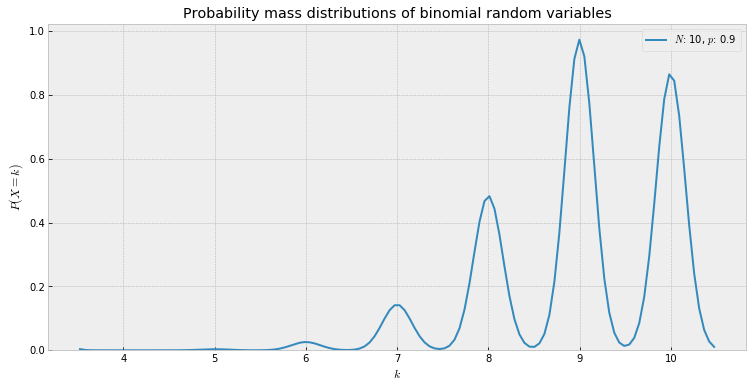

In [88]:
N = 10
p_1 = 0.4
p_2 = 0.9
sns.distplot(samples_x2,hist=False,kde=True, norm_hist=False ,label = f"$N$: {N}, $p$: {p_2}")
plt.xlabel("$k$")
plt.ylabel("$P(X = k)$")
plt.legend()
plt.title("Probability mass distributions of binomial random variables")

In [93]:
_x

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

##### Students Cheating

let $N$ be the total number of students who took the exam.

$X$ = "Yes I did cheat" answers. 

We then find the posterior distribution of $p$, given $N$, some specified prior on $p$, and observed data $X$. 

Assign Bernoulli random variables to the 100 students: 1 implies they cheated and 0 implies they did not.

In [97]:
N = 100
x = pm.Binomial.dist(n=1, p=0.5)
samples = x.random(size=N)

In [98]:
N = 100

with Model() as student_model:
    p = pm.Uniform('freq_cheating', lower= 0, upper=1)
    
    true_answers = pm.Bernoulli('truths', p, shape =N, testval=samples)

In [99]:
with student_model:
    first_coin_flips = pm.Bernoulli('first_flips', 0.5, shape=N, testval = samples)
print(first_coin_flips.tag.test_value)

[1 1 1 1 1 0 1 0 1 0 1 0 1 1 1 0 1 1 0 0 0 0 1 0 0 1 1 1 1 0 0 0 1 0 0 0 1
 1 1 1 1 1 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 0 1 1 0 1 0 1 1 0 0 1 1 0 0 0 0
 0 0 0 1 0 1 1 1 1 1 1 1 0 0 0 0 1 1 0 0 0 0 0 1 0 1]


In [100]:
with student_model:
        second_coin_flips = pm.Bernoulli("second_flips", 0.5, shape=N, testval=samples)

In [102]:
import theano.tensor as tt
with student_model:
    val = first_coin_flips*true_answers + (1 - first_coin_flips)*second_coin_flips
    observed_proportion = pm.Deterministic("observed_proportion", tt.sum(val)/float(N))

In [104]:
observed_proportion.tag.test_value

array(0.49000000953674316)

In [107]:
X =35

with student_model:
    observations = pm.Binomial("obs", N, observed_proportion, observed = X)

In [109]:
with student_model:
    step = pm.Metropolis(vars=[p])
    trace = pm.sample(40000, step=step)
    burned_trace = trace[15000:]

Assigned BinaryGibbsMetropolis to truths
Assigned BinaryGibbsMetropolis to first_flips
Assigned BinaryGibbsMetropolis to second_flips
100%|██████████| 40500/40500 [21:49<00:00, 30.93it/s] 


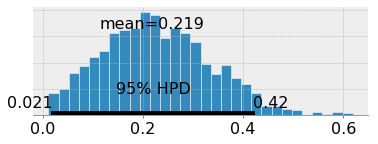

In [117]:
p_trace = burned_trace["freq_cheating"][15000:]
plot_posterior(p_trace)